In [1]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import h5py
import librosa
import os as os
import pandas as pd
import re
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score
from matplotlib import cm, colors, colorbar
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
rdg = RidgeClassifier(alpha=0.5)
#mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu',solver='sgd',learning_rate='constant',learning_rate_init=0.0001)
mlp=MLPClassifier(random_state=1,max_iter=300,activation='relu')
from sklearn.linear_model import LogisticRegression
lgr=LogisticRegression(random_state=1,max_iter=500)
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(random_state=0,max_depth=10)
from sklearn.ensemble import AdaBoostClassifier
adb = AdaBoostClassifier(n_estimators=100, random_state=0)
from sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(n_estimators=100, random_state=1)
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
from sklearn.linear_model import SGDClassifier
#SGD=SGDClassifier(loss= 'log',random_state=1,max_iter=100,early_stopping=True,learning_rate='optimal',validation_fraction=0.2)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
mmscaler= MinMaxScaler()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=10, random_state=0)
from sklearn.svm import SVC
clf_svm=SVC(kernel='rbf')
linear_svm=SVC(kernel='linear')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from scipy.stats.mstats import mquantiles
from scipy.stats import skew
from sklearn.cluster import KMeans
from sklearn.model_selection import LeaveOneOut
pca = PCA(n_components=2, svd_solver='full')
import random
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

2024-03-18 11:57:31.457199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 11:57:31.570870: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 11:57:32.069863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-18 11:57:32.069942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def read_eeg(data):
    with open(data) as f:
        raw = []
        for line in f:
            line = line.split() # to deal with blank 
            if line:            # lines (ie skip them)
                line = [int(float(i)) for i in line]
                raw.append(line)
    df = pd.DataFrame (raw,columns=['Channel_1','Channel_2','Channel_3','Channel_4','Channel_5','Channel_6','Channel_7','Channel_8',
                            'Channel_9','Channel_10','Channel_11','Channel_12','Channel_13','Channel_14','Channel_15'
                             ,'Channel_16','Channel_17','Channel_18','Channel_19'])
    return df

from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def noise_filter(df):
    filt_data=pd.Series()
    for i in range(0, df.shape[1]):
        signal = df.iloc[:,i].values
        data=butter_bandpass_filter(signal,0.1,45,128,3)
        
        filt_data=pd.concat([filt_data,pd.Series(data)],axis=1)
    filt_data=filt_data.iloc[:,1:]
    filt_data.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19']
    return filt_data

In [3]:
total_tps=34944-5*128 # cut all EEG of all subjects into equal length = 34944-5*128=34304 time points
number_of_epochs=26 # segment each subject's EEG into 26 epochs
number_of_tps=1280 # each epoch include 1280 time points

In [4]:
os.chdir("/home/jupy/Raw_data/Time_0/Obese")
ob_0=os.listdir(os.getcwd())
ob_0.remove('.ipynb_checkpoints')
#ob_0.remove('New')

eeg_ob_0=np.zeros([len(ob_0),total_tps,19])
for i in range(0,len(ob_0)):
    eeg_ob_0[i,:,:]=(read_eeg(ob_0[i]).values)[0:total_tps,:]

os.chdir("/home/jupy/Raw_data/Time_0/Lean")
l_0=os.listdir(os.getcwd())
l_0.remove('.ipynb_checkpoints')
#l_0.remove('New')

eeg_l_0=np.zeros([len(l_0),total_tps,19])
for i in range(0,len(l_0)):
    eeg_l_0[i,:,:]=(read_eeg(l_0[i]).values)[0:total_tps,:]
    
X_0=np.vstack([eeg_ob_0,eeg_l_0])
print ('eeg_ob_0',eeg_ob_0.shape)
print ('eeg_l_0',eeg_l_0.shape)
print('X_0',X_0.shape)

eeg_ob_0 (30, 34304, 19)
eeg_l_0 (30, 34304, 19)
X_0 (60, 34304, 19)


In [5]:
y=[0]*30+[1]*30

X_0_clean=np.zeros([60, 34304, 19])
for i in range(0,X_0.shape[0]):
    X_0_clean[i,:,:]=noise_filter(pd.DataFrame(X_0[i,:,:]))
X_0_clean=X_0_clean[:,0:int(number_of_epochs*number_of_tps),:]

X2_0=np.zeros([number_of_epochs*X_0_clean.shape[0],int(number_of_tps),19])
for chan in range(0,19):
    X1=np.zeros([number_of_epochs*X_0_clean.shape[0],int(number_of_tps)])
    for subj in range(0,X_0_clean.shape[0]):
        X1[subj*number_of_epochs:(subj+1)*number_of_epochs,:]=X_0_clean[subj,0:int(number_of_epochs*number_of_tps),chan].reshape(int(number_of_epochs),int(number_of_tps))
    X2_0[:,:,chan]=X1

/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object

/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filt_data=pd.Series()
/tmp/ipykernel_708216/877411679.py:27: FutureWarning: The default dtype for empty Series will be 'object

In [6]:
XX_0=np.zeros([X2_0.shape[0],19,number_of_tps])
for i in range(0,X2_0.shape[0]):
    XX_0[i,:,:]=X2_0[i,:,:].transpose()
print(XX_0.shape)

(1560, 19, 1280)


In [7]:
Y2=[]
for n in y:
    Y2=Y2+[n]*number_of_epochs
len(Y2)

1560

In [8]:
del eeg_l_0
del eeg_ob_0
del X_0
del X_0_clean
del X2_0

In [9]:
y_test_short=[1,1,1,0,0,0]

def subj_class_prob(result):
    pred=[]
    for i in range(0,6):
        #print(np.where(np.array(result[i*number_of_epochs:(i+1)*number_of_epochs])==1)[0].shape[0]/number_of_epochs)
        print(sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[0], sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[1])
        if sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[0]>sum(predicted[i*number_of_epochs:(i+1)*number_of_epochs])[1]:
            pred.append(0)
        else:
            pred.append(1)
    return pred

# DL

In [10]:
from keras_self_attention import SeqSelfAttention
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout,Add,LSTM,Reshape,Bidirectional
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D,AveragePooling1D,GlobalAveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Input, Conv1D,Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential, save_model, load_model
from tensorflow.keras.layers import Input, Conv1D,Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dense, Lambda, Reshape, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.preprocessing import minmax_scale

# VAE (build model + train)

# --------------------Feature extract------------------------------------------------------ 

In [11]:
#os.chdir('/home/jupy/ICPR_vae')
os.chdir('/home/jupy/SavedModel/autoencoder/T0_to_T0')
mm_feature_output_0_0={}
for n in range(0,60):#2-48
    xar_0=XX_0[n*26:(n+1)*26,:,:]
    xar_norm_0=np.zeros([xar_0.shape[0],xar_0.shape[1],xar_0.shape[2]])
    for i in range(0,xar_0.shape[0]):
        for j in range(0,xar_0.shape[1]):
            xar_norm_0[i,j,:]=minmax_scale(xar_0[i,j,:])
    xar_0=xar_norm_0
    xar_0=np.expand_dims(xar_0,axis=-1)
    #mm=load_model(f'vae{n}')
    mm=load_model(f'T0_to_T0_VAE{n}')
    intermediate_layer_model = Model(inputs=mm.input,outputs=mm.get_layer('spatial_conv').output)
    mm_feature_output_0_0[n]= intermediate_layer_model.predict(xar_0)
mm_feature_output_0_0[n].shape

2024-03-18 11:58:19.758383: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 11:58:19.766807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 11:58:19.767082: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-18 11:58:19.768423: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2024-03-18 11:58:21.155487: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8301


1/1 [==============================] - 1s 823ms/step


2024-03-18 11:58:21.457942: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 37ms/step


(26, 1, 1217, 8)

In [12]:
adapt_auto_feat_0_0=np.zeros([26*60,1,1217,8])
for n in range(0,60):
    adapt_auto_feat_0_0[n*26:(n+1)*26,:,:,:]=mm_feature_output_0_0[n]
Adapt_feat_0_0=np.zeros([26*60,1217*8])
for i in range(0,adapt_auto_feat_0_0.shape[0]):
    Adapt_feat_0_0[i,:]=adapt_auto_feat_0_0[i,:,:,:].flatten()

# TSNE 

In [16]:
xar_0=XX_0
xar_norm_0=np.zeros([xar_0.shape[0],xar_0.shape[1],xar_0.shape[2]])
for i in range(0,xar_0.shape[0]):
        for j in range(0,xar_0.shape[1]):
            xar_norm_0[i,j,:]=minmax_scale(xar_0[i,j,:])
xar_0=xar_norm_0
aaa=np.zeros([xar_0.shape[0],xar_0.shape[1]*xar_0.shape[2]])
for i in range(0,xar_0.shape[0]):
    aaa[i,:]=xar_0[i,:,:].flatten()
xar_0=aaa

from sklearn.manifold import TSNE
tsne= TSNE(n_components=2, perplexity=15,random_state=0)
tsne_raw=tsne.fit_transform(xar_0)
tsne_vae=tsne.fit_transform(Adapt_feat_0_0)

/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


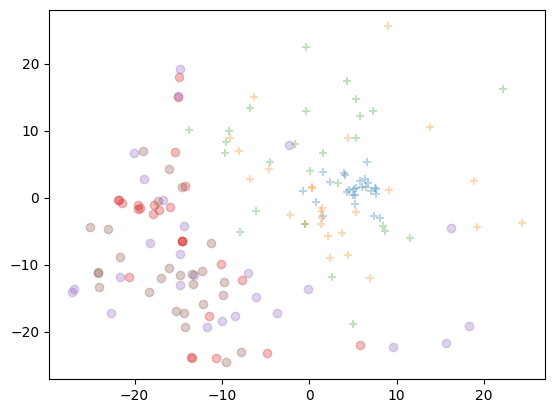

In [13]:
####### original VAE features - to delete latere ##############
from sklearn.manifold import TSNE
tsne= TSNE(n_components=2, perplexity=15)
tsne_vae=tsne.fit_transform(Adapt_feat_0_0)

##[0,10,22,29,55,40,50,59]

for i,marker, c in zip ([0,5,10,50,55,59] , ['+','+','+','o','o','o'],['red','red','red','green','green','green'],
                    ):
    plt.scatter(tsne_vae[i*26:(i+1)*26,0],tsne_vae[i*26:(i+1)*26,1],alpha=0.3,marker=marker)#,color=c
#plt.legend(loc="upper left")
####### original VAE features - to delete latere ##############

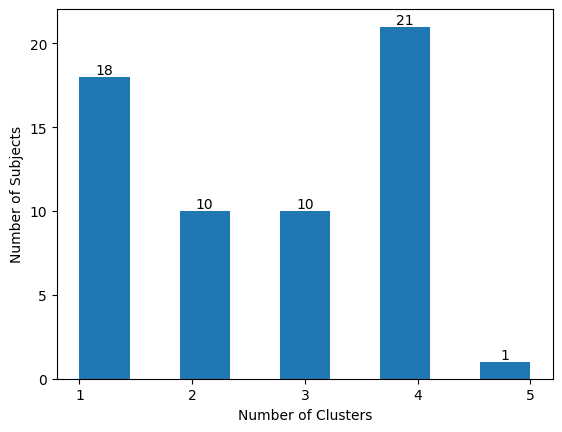

good subj [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
midhigh subj [18 19 20 21 22 23 24 25 26 34]
midlow subj [27 28 30 47 53 54 56 57 58 59]
bad subj [29 31 32 33 35 36 37 38 39 40 41 42 43 44 45 46 48 49 50 51 52 55]
Accuracy: 0.8397435897435898


In [13]:
from sklearn.cluster import KMeans
n_clusters = 5 # Number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(Adapt_feat_0_0)
cluster_assignments = kmeans.labels_

cluster_assignments.shape
cluster_purity=[]
for i in range(0,60):
    cluster_count=(np.unique(cluster_assignments[i*26:(i+1)*26], return_counts=True)[0].shape[0])
    cluster_purity.append(cluster_count)
    
counts, bins, _ = plt.hist(cluster_purity, bins=9)
for count, x in zip(counts, bins):
    if count > 0:  # Remove 0 count
        plt.text(x + (bins[1] - bins[0]) / 2, count, str(int(count)), ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Number of Clusters')
plt.ylabel('Number of Subjects')
plt.xticks(range(1, 6))  # Set the x-axis to start from 1 to 9
plt.yticks(range(0, 23, 5))  # Set the y-axis range from 0 to 22 with intervals of 5
plt.show()
good_q_id=np.where(np.array(cluster_purity)<=1.5)[0]
midhigh_q_id = np.where((1.7 < np.array(cluster_purity)) & (np.array(cluster_purity) <=2.5))[0]
midlow_q_id = np.where((2.5< np.array(cluster_purity)) & (np.array(cluster_purity) <= 3))[0]
bad_q_id = np.where(np.array(cluster_purity)>3.5)[0]

print('good subj',good_q_id)
print('midhigh subj',midhigh_q_id)
print('midlow subj',midlow_q_id)
print('bad subj',bad_q_id)

quality_y=np.empty([1560,])
#quality_ar=np.zeros[1560,9736]
for i in good_q_id:
    #print(np.arange(i*26,(i+1)*26))
    quality_y[np.arange(i*26,(i+1)*26)]=0
    
for j in midhigh_q_id:
    quality_y[np.arange(j*26,(j+1)*26)]=1
    
for r in midlow_q_id:
    quality_y[np.arange(r*26,(r+1)*26)]=1
    
for z in bad_q_id:
    quality_y[np.arange(z*26,(z+1)*26)]=2
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Number of trees in the Random Forest
n_estimators = 200

# Create a Random Forest classifier with bootstrapping
rf = RandomForestClassifier(n_estimators=n_estimators, bootstrap=True)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Adapt_feat_0_0, quality_y, test_size=0.2, random_state=42,stratify=quality_y
)#, 
# Train the Random Forest model
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

rf.feature_importances_
feat_id=rf.feature_importances_.argsort()[-500:][::-1]

/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupy/.conda/envs/venv_py39/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


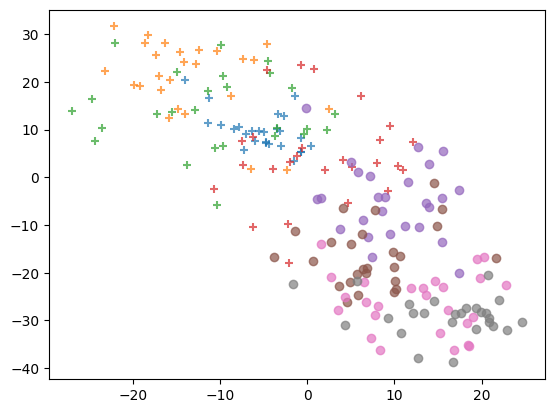

In [18]:
from sklearn.manifold import TSNE
tsne= TSNE(n_components=2, perplexity=15)
tsne_vae=tsne.fit_transform(Adapt_feat_0_0[:,feat_id])
#tsne_vae=tsne.fit_transform(xar_0[:,feat_id])

for i,marker, c in zip ([0,15,21,27,37,43,52,59] , ['+','+','+','+','o','o','o','o'],['red','red','red','red','green','green','green','green'],                  ):
    plt.scatter(tsne_vae[i*26:(i+1)*26,0],tsne_vae[i*26:(i+1)*26,1],alpha=0.7,marker=marker)#,color=c
#plt.legend(labels=['Lean', 'Obese'], loc='upper right')
os.chdir('/home/jupy/ICPR_plots')
plt.savefig(r'tsne_samp_vae.pdf', dpi=300)

In [ ]:
tsne_feat=tsne_raw
plt.scatter(tsne_feat[np.where(np.array(Y2)==0)[0],0],tsne_feat[np.where(np.array(Y2)==0)[0],1],alpha=0.3,label="Obese")
plt.scatter(tsne_feat[np.where(np.array(Y2)==1)[0],0],tsne_feat[np.where(np.array(Y2)==1)[0],1],alpha=0.3,label="Lean")
plt.legend(loc="upper left")
#plt.gcf()
os.chdir('/home/jupy/ICPR2024/plots')
#plt.savefig(r'tsne_raw.pdf', dpi=300)

In [ ]:
tsne_feat=tsne_raw
for subj,marker in zip( [7,10,2,16,25,35,39,43,56,58],['+','+','+','+','+','o','o','o','o','o']):
    plt.scatter(tsne_feat[subj*number_of_epochs:(subj+1)*number_of_epochs,0],
                tsne_feat[subj*number_of_epochs:(subj+1)*number_of_epochs,1],alpha=0.8, marker=marker)
#plt.savefig(r'tsne_raw_10subj.pdf', dpi=300)

In [ ]:
tsne_feat=tsne_vae
plt.scatter(tsne_feat[np.where(np.array(Y2)==0)[0],0],tsne_feat[np.where(np.array(Y2)==0)[0],1],alpha=0.3,label="Obese")
plt.scatter(tsne_feat[np.where(np.array(Y2)==1)[0],0],tsne_feat[np.where(np.array(Y2)==1)[0],1],alpha=0.3,label="Lean")
plt.legend(loc="upper left")
#plt.gcf()
os.chdir('/home/jupy/ICPR2024/plots')
#plt.savefig(r'tsne_vae.pdf', dpi=300)

In [ ]:
tsne_feat=tsne_vae
for subj,marker in zip( [0,5,11,19,16,26,34,37,48,56,59],['+','+','+','+','o','o','o','o']):
    plt.scatter(tsne_feat[subj*number_of_epochs:(subj+1)*number_of_epochs,0],
                tsne_feat[subj*number_of_epochs:(subj+1)*number_of_epochs,1],alpha=0.8, marker=marker)
#plt.savefig(r'tsne_vae_10subj.pdf', dpi=300)

In [ ]:
for i,c,lab in zip ( [2,5,18,21,24,31,40,56], ['red','red','red','red','red','green','green','green'],
                    ["Obese","Obese","Obese","Obese","Obese","lean","lean","lean"]):
    plt.scatter(tsne_feat_dann[i*26:(i+1)*26,0],tsne_feat_dann[i*26:(i+1)*26,1],alpha=0.3,c=c,label=lab)
plt.legend(loc="upper left")

# Train/Test split

In [11]:
XX_0.shape

(1560, 19, 1280)

In [12]:
data_ind=[]
for n in range(0,10):
    data_ind.append(np.array([30,31,32,0,1,2])+n*3)

Xtest_id={}
Xtv_id={}

for s in range(0,10):    
    Xtest_id[s]=data_ind[s]
    #Xtv_id[s]=flatten(data_ind[0:s]+data_ind[(s+1):])
    Xtv_id[s]=(np.array(data_ind[0:s]).flatten().tolist())+(np.array(data_ind[(s+1):]).flatten().tolist())
    print('set',s,Xtest_id[s])
    print('set',s,Xtv_id[s])
    print('----------------------------')
    
Xdata= XX_0#Adapt_feat_0_0
Ydata=np.array(Y2)
Xtv={}
Ytv={}
Xtest={}
Ytest={}
for s in range(0,10):
    print('set',s)
    Xtest[s]=np.zeros([Xdata.shape[0],Xdata.shape[1],Xdata.shape[2] ])#
    Ytest[s]=np.zeros([Xdata.shape[0],])
    print('test_id',Xtest_id[s])
    for test_id in Xtest_id[s]:
            Xtest[s]=np.vstack([Xtest[s],Xdata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,:,:]])
            Ytest[s]=np.hstack([Ytest[s],Ydata[test_id*number_of_epochs:(test_id+1)*number_of_epochs,]])
          
    Xtest[s]=Xtest[s][Xdata.shape[0]:,:,:] 
    Ytest[s]=Ytest[s][Xdata.shape[0]:,] 
    
    Xtv[s]=np.zeros([Xdata.shape[0],Xdata.shape[1],Xdata.shape[2]])#
    Ytv[s]=np.zeros([Xdata.shape[0],])
    print('tv_id',Xtv_id[s])
    for tv_id in Xtv_id[s]:
            Xtv[s]=np.vstack([Xtv[s],Xdata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,:,:]])
            Ytv[s]=np.hstack([Ytv[s],Ydata[tv_id*number_of_epochs:(tv_id+1)*number_of_epochs,]])
            
    Xtv[s]=Xtv[s][Xdata.shape[0]:,:,:] 
    Ytv[s]=Ytv[s][Xdata.shape[0]:,] 

set 0 [30 31 32  0  1  2]
set 0 [33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 1 [33 34 35  3  4  5]
set 1 [30, 31, 32, 0, 1, 2, 36, 37, 38, 6, 7, 8, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 2 [36 37 38  6  7  8]
set 2 [30, 31, 32, 0, 1, 2, 33, 34, 35, 3, 4, 5, 39, 40, 41, 9, 10, 11, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22, 23, 54, 55, 56, 24, 25, 26, 57, 58, 59, 27, 28, 29]
----------------------------
set 3 [39 40 41  9 10 11]
set 3 [30, 31, 32, 0, 1, 2, 33, 34, 35, 3, 4, 5, 36, 37, 38, 6, 7, 8, 42, 43, 44, 12, 13, 14, 45, 46, 47, 15, 16, 17, 48, 49, 50, 18, 19, 20, 51, 52, 53, 21, 22,

In [13]:
all_id_long={}
X_all_shuffled={}
Y_all_shuffled={}
Y_all_shuffled_cat={}
for s in range(0,10):
    np.random.seed(2)
    all_id_long[s]=np.arange(0,Xtv[s].shape[0])
    np.random.shuffle(all_id_long[s])
    
    X_all_shuffled[s]=np.zeros([ Xtv[s].shape[0], Xtv[s].shape[1], Xtv[s].shape[2]])
    Y_all_shuffled[s]=np.zeros([ Xtv[s].shape[0]])
    for n in range(0,all_id_long[s].shape[0]):
        X_all_shuffled[s][n,:]=Xtv[s][all_id_long[s][n],:,:]
        #print(n,all_id_long[s][n])
        Y_all_shuffled[s][n]=Ytv[s][all_id_long[s][n]]
    print(X_all_shuffled[s].shape)
    print(Y_all_shuffled[s].shape)

(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)
(1404, 19, 1280)
(1404,)


In [14]:
for s in range(0,10):
    del  Xtv[s]

## VGG

In [19]:
input_shape

(19, 1280)

In [33]:
from tensorflow.keras.layers import Input, Conv1D, concatenate, Add, GlobalAveragePooling1D, Dense, Multiply, Activation
from tensorflow.keras.models import Model

def attention_vgg_residual_inception(input_shape, filters, num_classes):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # VGG Block
    vgg_conv1 = Conv1D(filters[0], 3, activation='relu', padding='same')(input_layer)
    vgg_conv2 = Conv1D(filters[1], 3, activation='relu', padding='same')(vgg_conv1)
    
    # Residual Block
    residual_conv1 = Conv1D(filters[2], 1, activation='relu', padding='same')(input_layer)
    residual_conv2 = Conv1D(filters[3], 3, activation='relu', padding='same')(residual_conv1)
    residual_conv3 = Conv1D(filters[4], 1, activation='relu', padding='same')(residual_conv2)
    
    # Inception Block
    inception_conv1 = Conv1D(filters[5], 1, activation='relu', padding='same')(input_layer)
    inception_conv3 = Conv1D(filters[6], 3, activation='relu', padding='same')(input_layer)
    inception_conv5 = Conv1D(filters[7], 5, activation='relu', padding='same')(input_layer)
    inception_output = concatenate([inception_conv1, inception_conv3, inception_conv5], axis=-1)
    
    # Attention Mechanism
    attention_weights = Conv1D(1, 1, activation='softmax', padding='same')(inception_output)
    attention_output = Multiply()([inception_output, attention_weights])
    
    # Reshape to match the number of channels
    residual_conv1 = Conv1D(filters[4], 1, activation='relu', padding='same')(residual_conv1)
    
    # Element-wise addition
    residual_output = Add()([residual_conv3, residual_conv1])
    
    # Global Average Pooling
    gap = GlobalAveragePooling1D()(attention_output)
    
    # Fully Connected Layer
    fc1 = Dense(64, activation='relu')(gap)
    
    # Output layer
    output = Dense(num_classes, activation='sigmoid')(fc1)
    
    # Build model
    model = Model(inputs=input_layer, outputs=output)
    return model

# Example usage
input_shape = (19, 1280)
filters = [64, 128, 64, 128, 64, 64, 64, 64]  # Example filter sizes, adjust as needed
num_classes = 2  # Binary classification
vgg_mod= attention_vgg_residual_inception(input_shape, filters, num_classes)
vgg_mod.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 19, 1280)]   0           []                               
                                                                                                  
 conv1d_195 (Conv1D)            (None, 19, 64)       81984       ['input_23[0][0]']               
                                                                                                  
 conv1d_196 (Conv1D)            (None, 19, 64)       245824      ['input_23[0][0]']               
                                                                                                  
 conv1d_197 (Conv1D)            (None, 19, 64)       409664      ['input_23[0][0]']               
                                                                                           

In [37]:
for s in range(0,10):
    adam=tf.keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0005
    vgg_mod=attention_vgg_residual_inception(input_shape, filters, num_classes)
    vgg_mod.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40,restore_best_weights = True)
    history=vgg_mod.fit( X_all_shuffled[s].reshape(1404, 19, 1280,1),# 
                         to_categorical(Y_all_shuffled[s]),epochs=200, batch_size=200, validation_split=0.2, callbacks=[callback],verbose=1)   
    os.chdir('/home/jupy/ICPR_VGG')
    tf.keras.models.save_model(vgg_mod,filepath=f'vgg_mod{s}',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)

Epoch 1/200
6/6 [==============================] - 1s 44ms/step - loss: 5.3822 - accuracy: 0.5102 - val_loss: 4.0602 - val_accuracy: 0.5125
Epoch 2/200
6/6 [==============================] - 0s 19ms/step - loss: 3.2513 - accuracy: 0.5708 - val_loss: 3.4717 - val_accuracy: 0.5089
Epoch 3/200
6/6 [==============================] - 1s 210ms/step - loss: 2.2213 - accuracy: 0.6180 - val_loss: 3.0965 - val_accuracy: 0.5267
Epoch 4/200
6/6 [==============================] - 4s 799ms/step - loss: 1.5017 - accuracy: 0.6812 - val_loss: 3.0318 - val_accuracy: 0.5160
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.0649 - accuracy: 0.7418 - val_loss: 2.7678 - val_accuracy: 0.5445
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 0.7282 - accuracy: 0.7890 - val_loss: 2.7263 - val_accuracy: 0.5302
Epoch 7/200
6/6 [==============================] - 3s 587ms/step - loss: 0.4816 - accuracy: 0.8513 - val_loss: 2.8100 - val_accuracy: 0.5231
Epoch 8/200
6/6 [

INFO:tensorflow:Assets written to: vgg_mod0/assets


INFO:tensorflow:Assets written to: vgg_mod0/assets


Epoch 1/200
6/6 [==============================] - 1s 44ms/step - loss: 5.9018 - accuracy: 0.5138 - val_loss: 4.5992 - val_accuracy: 0.5338
Epoch 2/200
6/6 [==============================] - 0s 17ms/step - loss: 3.5535 - accuracy: 0.6020 - val_loss: 4.4812 - val_accuracy: 0.5231
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 2.1360 - accuracy: 0.6527 - val_loss: 4.5857 - val_accuracy: 0.5302
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 1.6393 - accuracy: 0.6990 - val_loss: 4.2581 - val_accuracy: 0.5445
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.0963 - accuracy: 0.7489 - val_loss: 4.0241 - val_accuracy: 0.5018
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 0.6831 - accuracy: 0.8112 - val_loss: 3.9084 - val_accuracy: 0.4982
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.4520 - accuracy: 0.8727 - val_loss: 3.8221 - val_accuracy: 0.4875
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: vgg_mod1/assets


INFO:tensorflow:Assets written to: vgg_mod1/assets


Epoch 1/200
6/6 [==============================] - 1s 44ms/step - loss: 7.8039 - accuracy: 0.5298 - val_loss: 7.5263 - val_accuracy: 0.4875
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 4.8474 - accuracy: 0.5476 - val_loss: 4.9915 - val_accuracy: 0.5018
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 3.3070 - accuracy: 0.5922 - val_loss: 4.8582 - val_accuracy: 0.5089
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 2.3464 - accuracy: 0.6465 - val_loss: 4.8643 - val_accuracy: 0.5196
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.7530 - accuracy: 0.6839 - val_loss: 4.1325 - val_accuracy: 0.5302
Epoch 6/200
6/6 [==============================] - 1s 276ms/step - loss: 1.2575 - accuracy: 0.7257 - val_loss: 3.9598 - val_accuracy: 0.5302
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.8886 - accuracy: 0.7809 - val_loss: 4.0107 - val_accuracy: 0.4947
Epoch 8/200
6/6 [==

INFO:tensorflow:Assets written to: vgg_mod2/assets


INFO:tensorflow:Assets written to: vgg_mod2/assets


Epoch 1/200
6/6 [==============================] - 1s 44ms/step - loss: 6.5032 - accuracy: 0.5004 - val_loss: 3.6268 - val_accuracy: 0.5196
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 3.8299 - accuracy: 0.5539 - val_loss: 3.2957 - val_accuracy: 0.5623
Epoch 3/200
6/6 [==============================] - 0s 19ms/step - loss: 2.5963 - accuracy: 0.6109 - val_loss: 3.9449 - val_accuracy: 0.5374
Epoch 4/200
6/6 [==============================] - 0s 17ms/step - loss: 2.2001 - accuracy: 0.6492 - val_loss: 3.7675 - val_accuracy: 0.5302
Epoch 5/200
6/6 [==============================] - 0s 17ms/step - loss: 1.5879 - accuracy: 0.7186 - val_loss: 3.9950 - val_accuracy: 0.5552
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.1685 - accuracy: 0.7489 - val_loss: 3.7891 - val_accuracy: 0.5409
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.7526 - accuracy: 0.8139 - val_loss: 3.5256 - val_accuracy: 0.5053
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: vgg_mod3/assets


INFO:tensorflow:Assets written to: vgg_mod3/assets


Epoch 1/200
6/6 [==============================] - 1s 44ms/step - loss: 6.0156 - accuracy: 0.4915 - val_loss: 5.3632 - val_accuracy: 0.5196
Epoch 2/200
6/6 [==============================] - 0s 17ms/step - loss: 3.9069 - accuracy: 0.5352 - val_loss: 4.2266 - val_accuracy: 0.4875
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 2.9361 - accuracy: 0.5726 - val_loss: 3.9893 - val_accuracy: 0.4804
Epoch 4/200
6/6 [==============================] - 0s 17ms/step - loss: 2.0487 - accuracy: 0.6447 - val_loss: 4.0701 - val_accuracy: 0.4840
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.5297 - accuracy: 0.6848 - val_loss: 3.8943 - val_accuracy: 0.5018
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.0758 - accuracy: 0.7524 - val_loss: 3.5233 - val_accuracy: 0.5160
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.7357 - accuracy: 0.8148 - val_loss: 3.5460 - val_accuracy: 0.5089
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: vgg_mod4/assets


INFO:tensorflow:Assets written to: vgg_mod4/assets


Epoch 1/200
6/6 [==============================] - 1s 45ms/step - loss: 6.4707 - accuracy: 0.5120 - val_loss: 3.6025 - val_accuracy: 0.4911
Epoch 2/200
6/6 [==============================] - 0s 17ms/step - loss: 3.0468 - accuracy: 0.5450 - val_loss: 4.5687 - val_accuracy: 0.5302
Epoch 3/200
6/6 [==============================] - 0s 19ms/step - loss: 2.2390 - accuracy: 0.6002 - val_loss: 3.2609 - val_accuracy: 0.5409
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 1.5364 - accuracy: 0.6661 - val_loss: 2.9995 - val_accuracy: 0.5338
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 0.9656 - accuracy: 0.7311 - val_loss: 2.8374 - val_accuracy: 0.5267
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 0.6399 - accuracy: 0.7872 - val_loss: 2.7342 - val_accuracy: 0.5267
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.4550 - accuracy: 0.8504 - val_loss: 2.4796 - val_accuracy: 0.5338
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: vgg_mod5/assets


INFO:tensorflow:Assets written to: vgg_mod5/assets


Epoch 1/200
6/6 [==============================] - 1s 46ms/step - loss: 6.4364 - accuracy: 0.4987 - val_loss: 4.0002 - val_accuracy: 0.5018
Epoch 2/200
6/6 [==============================] - 0s 17ms/step - loss: 3.8096 - accuracy: 0.5485 - val_loss: 4.3418 - val_accuracy: 0.5160
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 2.3691 - accuracy: 0.6376 - val_loss: 3.9193 - val_accuracy: 0.5053
Epoch 4/200
6/6 [==============================] - 0s 19ms/step - loss: 2.0726 - accuracy: 0.6598 - val_loss: 3.8648 - val_accuracy: 0.5196
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.5641 - accuracy: 0.7026 - val_loss: 3.5996 - val_accuracy: 0.5623
Epoch 6/200
6/6 [==============================] - 0s 20ms/step - loss: 1.0042 - accuracy: 0.7720 - val_loss: 3.3054 - val_accuracy: 0.5409
Epoch 7/200
6/6 [==============================] - 0s 21ms/step - loss: 0.6584 - accuracy: 0.8255 - val_loss: 3.1508 - val_accuracy: 0.5480
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: vgg_mod6/assets


INFO:tensorflow:Assets written to: vgg_mod6/assets


Epoch 1/200
6/6 [==============================] - 1s 47ms/step - loss: 5.2700 - accuracy: 0.4996 - val_loss: 4.3924 - val_accuracy: 0.4626
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 2.9863 - accuracy: 0.5628 - val_loss: 3.4667 - val_accuracy: 0.5125
Epoch 3/200
6/6 [==============================] - 0s 17ms/step - loss: 2.2131 - accuracy: 0.6305 - val_loss: 3.6642 - val_accuracy: 0.4769
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 1.5128 - accuracy: 0.6768 - val_loss: 3.4600 - val_accuracy: 0.5018
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.0292 - accuracy: 0.7444 - val_loss: 3.2667 - val_accuracy: 0.5053
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 0.7420 - accuracy: 0.7890 - val_loss: 3.4137 - val_accuracy: 0.5267
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.5424 - accuracy: 0.8451 - val_loss: 3.3519 - val_accuracy: 0.4982
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: vgg_mod7/assets


INFO:tensorflow:Assets written to: vgg_mod7/assets


Epoch 1/200
6/6 [==============================] - 2s 46ms/step - loss: 11.6763 - accuracy: 0.4835 - val_loss: 6.2362 - val_accuracy: 0.5053
Epoch 2/200
6/6 [==============================] - 0s 19ms/step - loss: 6.0985 - accuracy: 0.5245 - val_loss: 5.7559 - val_accuracy: 0.5053
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 4.1937 - accuracy: 0.5628 - val_loss: 4.3292 - val_accuracy: 0.5338
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 2.7671 - accuracy: 0.6046 - val_loss: 4.3982 - val_accuracy: 0.5302
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.9308 - accuracy: 0.6830 - val_loss: 4.1964 - val_accuracy: 0.5231
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 1.3780 - accuracy: 0.7551 - val_loss: 4.0607 - val_accuracy: 0.5089
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.9962 - accuracy: 0.7925 - val_loss: 3.8193 - val_accuracy: 0.5231
Epoch 8/200
6/6 [==

INFO:tensorflow:Assets written to: vgg_mod8/assets


INFO:tensorflow:Assets written to: vgg_mod8/assets


Epoch 1/200
6/6 [==============================] - 1s 45ms/step - loss: 12.4378 - accuracy: 0.5067 - val_loss: 6.4266 - val_accuracy: 0.5231
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 5.8224 - accuracy: 0.5361 - val_loss: 6.4063 - val_accuracy: 0.4484
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 4.6061 - accuracy: 0.5672 - val_loss: 5.2317 - val_accuracy: 0.4769
Epoch 4/200
6/6 [==============================] - 0s 19ms/step - loss: 3.5412 - accuracy: 0.5922 - val_loss: 4.9271 - val_accuracy: 0.4733
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 2.7140 - accuracy: 0.6402 - val_loss: 4.7356 - val_accuracy: 0.5089
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.9414 - accuracy: 0.6812 - val_loss: 4.3451 - val_accuracy: 0.5018
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 1.3589 - accuracy: 0.7418 - val_loss: 4.1185 - val_accuracy: 0.5160
Epoch 8/200
6/6 [==

INFO:tensorflow:Assets written to: vgg_mod9/assets


INFO:tensorflow:Assets written to: vgg_mod9/assets


In [38]:
os.chdir('/home/jupy/ICPR_VGG')
avg_score=0
for s in range(0,10):
    classifier=load_model(f'vgg_mod{s}')
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)
    avg_score=avg_score+accuracy_score(pred,y_test_short)
    print('score',accuracy_score(pred,y_test_short))
print(avg_score/10)

5/5 [==============================] - 2s 25ms/step
ep score 0.5641025641025641
23.818039 25.626497
25.170145 25.809319
25.691107 25.54649
25.296503 21.367012
23.229858 24.117794
24.688972 24.872889
score 0.5
5/5 [==============================] - 0s 2ms/step
ep score 0.5897435897435898
15.877361 13.251434
11.568411 20.966969
8.478392 9.962566
12.110574 15.054521
16.629915 15.873425
14.335865 14.591357
score 0.5
5/5 [==============================] - 0s 3ms/step
ep score 0.5448717948717948
2.7949274 3.191945
2.0466614 1.1973666
3.3379679 4.2124023
6.0490127 0.9468225
5.9539595 4.1894817
1.5500462 1.5971104
score 0.6666666666666666
5/5 [==============================] - 0s 2ms/step
ep score 0.47435897435897434
15.237129 17.256319
17.71248 18.657547
14.040426 11.200073
17.021805 16.055399
12.782481 15.698158
9.803522 12.230139
score 0.5
5/5 [==============================] - 0s 2ms/step
ep score 0.5
0.9931742 1.289728
0.018786695 0.26510155
1.2980843 0.7630377
2.9249277 0.63093674
1.7277

# CNN_LSTM

In [41]:
def cnn_lstm_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # Reshape the input to (time steps, features)
    reshaped_input = Reshape((input_shape[0], input_shape[1], 1))(input_layer)
    
    # CNN layers
    cnn_conv1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(reshaped_input)
    cnn_conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(cnn_conv1)
    cnn_maxpool = MaxPooling2D(pool_size=(2, 2))(cnn_conv2)
    
    # Reshape the output of CNN layers to (time steps, features)
    cnn_output = Reshape((-1, cnn_maxpool.shape[2] * cnn_maxpool.shape[3]))(cnn_maxpool)
    
    # LSTM layer
    lstm = LSTM(128)(cnn_output)
    
    # Output layer
    output = Dense(2, activation='sigmoid')(lstm)
    
    # Build model
    model = Model(inputs=input_layer, outputs=output)
    return model

# Example usage
input_shape = (19, 1280)
cnn_lstm = cnn_lstm_model(input_shape)
cnn_lstm.summary()

Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 19, 1280)]        0         
                                                                 
 reshape_3 (Reshape)         (None, 19, 1280, 1)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 1278, 32)      320       
                                                                 
 conv2d_5 (Conv2D)           (None, 15, 1276, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 638, 64)       0         
 2D)                                                             
                                                                 
 reshape_4 (Reshape)         (None, 7, 40832)          0         
                                                          

In [42]:
for s in range(0,10):
    adam=tf.keras.optimizers.Adam(learning_rate=0.0001)#learning_rate=0.0005
    cnn_lstm=attention_vgg_residual_inception(input_shape, filters, num_classes)
    cnn_lstm.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=40,restore_best_weights = True)
    history=cnn_lstm.fit( X_all_shuffled[s].reshape(1404, 19, 1280,1),# 
                         to_categorical(Y_all_shuffled[s]),epochs=200, batch_size=200, validation_split=0.2, callbacks=[callback],verbose=1)   
    os.chdir('/home/jupy/ICPR_2dCNN_LSTM')
    tf.keras.models.save_model(cnn_lstm,filepath=f'cnn_lstm{s}',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)

Epoch 1/200
6/6 [==============================] - 1s 48ms/step - loss: 6.3747 - accuracy: 0.4978 - val_loss: 5.0755 - val_accuracy: 0.5160
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 4.2471 - accuracy: 0.5619 - val_loss: 4.7924 - val_accuracy: 0.5445
Epoch 3/200
6/6 [==============================] - 0s 19ms/step - loss: 2.6673 - accuracy: 0.6242 - val_loss: 4.6285 - val_accuracy: 0.5302
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 2.1398 - accuracy: 0.6483 - val_loss: 4.7003 - val_accuracy: 0.5196
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.4728 - accuracy: 0.7035 - val_loss: 3.8036 - val_accuracy: 0.5694
Epoch 6/200
6/6 [==============================] - 0s 17ms/step - loss: 1.0150 - accuracy: 0.7729 - val_loss: 4.1280 - val_accuracy: 0.5231
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.6678 - accuracy: 0.8121 - val_loss: 3.7495 - val_accuracy: 0.5267
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm0/assets


INFO:tensorflow:Assets written to: cnn_lstm0/assets


Epoch 1/200
6/6 [==============================] - 1s 45ms/step - loss: 8.1531 - accuracy: 0.4826 - val_loss: 5.9345 - val_accuracy: 0.4484
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 4.6724 - accuracy: 0.5352 - val_loss: 5.7541 - val_accuracy: 0.4555
Epoch 3/200
6/6 [==============================] - 0s 19ms/step - loss: 3.4009 - accuracy: 0.5592 - val_loss: 4.0923 - val_accuracy: 0.4840
Epoch 4/200
6/6 [==============================] - 0s 19ms/step - loss: 2.4598 - accuracy: 0.6242 - val_loss: 3.7694 - val_accuracy: 0.5231
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.7438 - accuracy: 0.6830 - val_loss: 3.6907 - val_accuracy: 0.5125
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.2708 - accuracy: 0.7231 - val_loss: 3.3140 - val_accuracy: 0.5267
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.8958 - accuracy: 0.7747 - val_loss: 3.3590 - val_accuracy: 0.5125
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm1/assets


INFO:tensorflow:Assets written to: cnn_lstm1/assets


Epoch 1/200
6/6 [==============================] - 1s 46ms/step - loss: 11.6490 - accuracy: 0.5156 - val_loss: 6.5014 - val_accuracy: 0.4911
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 6.2043 - accuracy: 0.5191 - val_loss: 6.0303 - val_accuracy: 0.4840
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 4.1163 - accuracy: 0.5726 - val_loss: 4.8293 - val_accuracy: 0.5018
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 2.7973 - accuracy: 0.6305 - val_loss: 4.2802 - val_accuracy: 0.5196
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 2.0429 - accuracy: 0.6723 - val_loss: 3.7008 - val_accuracy: 0.5160
Epoch 6/200
6/6 [==============================] - 0s 17ms/step - loss: 1.2610 - accuracy: 0.7320 - val_loss: 4.0007 - val_accuracy: 0.5125
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.9223 - accuracy: 0.7649 - val_loss: 3.6550 - val_accuracy: 0.5053
Epoch 8/200
6/6 [==

INFO:tensorflow:Assets written to: cnn_lstm2/assets


INFO:tensorflow:Assets written to: cnn_lstm2/assets


Epoch 1/200
6/6 [==============================] - 1s 144ms/step - loss: 5.7632 - accuracy: 0.4684 - val_loss: 4.8427 - val_accuracy: 0.4840
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 4.9421 - accuracy: 0.5459 - val_loss: 4.0775 - val_accuracy: 0.5267
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 2.7697 - accuracy: 0.6064 - val_loss: 3.9232 - val_accuracy: 0.5196
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8353 - accuracy: 0.6723 - val_loss: 3.5953 - val_accuracy: 0.5302
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 1.4709 - accuracy: 0.7186 - val_loss: 3.5412 - val_accuracy: 0.5445
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 1.0749 - accuracy: 0.7524 - val_loss: 3.3090 - val_accuracy: 0.5730
Epoch 7/200
6/6 [==============================] - 0s 19ms/step - loss: 0.7239 - accuracy: 0.8077 - val_loss: 3.0708 - val_accuracy: 0.5658
Epoch 8/200
6/6 [==

INFO:tensorflow:Assets written to: cnn_lstm3/assets


INFO:tensorflow:Assets written to: cnn_lstm3/assets


Epoch 1/200
6/6 [==============================] - 1s 45ms/step - loss: 7.5277 - accuracy: 0.5174 - val_loss: 5.1413 - val_accuracy: 0.5196
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 4.8716 - accuracy: 0.5423 - val_loss: 4.6628 - val_accuracy: 0.4911
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 3.3243 - accuracy: 0.6037 - val_loss: 4.4025 - val_accuracy: 0.5374
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 2.4288 - accuracy: 0.6456 - val_loss: 3.7996 - val_accuracy: 0.5445
Epoch 5/200
6/6 [==============================] - 0s 17ms/step - loss: 1.7949 - accuracy: 0.6910 - val_loss: 3.9117 - val_accuracy: 0.5409
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.4698 - accuracy: 0.7240 - val_loss: 3.5545 - val_accuracy: 0.5374
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 1.0712 - accuracy: 0.7720 - val_loss: 3.5785 - val_accuracy: 0.5338
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm4/assets


INFO:tensorflow:Assets written to: cnn_lstm4/assets


Epoch 1/200
6/6 [==============================] - 1s 45ms/step - loss: 5.6344 - accuracy: 0.5174 - val_loss: 4.2162 - val_accuracy: 0.5267
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 3.3273 - accuracy: 0.5815 - val_loss: 4.0014 - val_accuracy: 0.5445
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 2.3728 - accuracy: 0.6037 - val_loss: 4.0232 - val_accuracy: 0.5658
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 1.8317 - accuracy: 0.6483 - val_loss: 3.4186 - val_accuracy: 0.5338
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.1521 - accuracy: 0.7106 - val_loss: 3.4001 - val_accuracy: 0.5552
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 0.7855 - accuracy: 0.7703 - val_loss: 2.9907 - val_accuracy: 0.5552
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.4968 - accuracy: 0.8379 - val_loss: 3.0263 - val_accuracy: 0.5694
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm5/assets


INFO:tensorflow:Assets written to: cnn_lstm5/assets


Epoch 1/200
6/6 [==============================] - 1s 52ms/step - loss: 4.4256 - accuracy: 0.5111 - val_loss: 3.7339 - val_accuracy: 0.5160
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 2.7187 - accuracy: 0.6162 - val_loss: 3.7234 - val_accuracy: 0.5053
Epoch 3/200
6/6 [==============================] - 0s 21ms/step - loss: 2.0729 - accuracy: 0.6278 - val_loss: 3.1750 - val_accuracy: 0.5125
Epoch 4/200
6/6 [==============================] - 0s 20ms/step - loss: 1.7073 - accuracy: 0.6687 - val_loss: 3.0723 - val_accuracy: 0.4804
Epoch 5/200
6/6 [==============================] - 0s 19ms/step - loss: 1.1114 - accuracy: 0.7435 - val_loss: 3.2924 - val_accuracy: 0.4911
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 0.8166 - accuracy: 0.7854 - val_loss: 2.8016 - val_accuracy: 0.5231
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.5514 - accuracy: 0.8308 - val_loss: 2.8112 - val_accuracy: 0.5338
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm6/assets


INFO:tensorflow:Assets written to: cnn_lstm6/assets


Epoch 1/200
6/6 [==============================] - 1s 46ms/step - loss: 6.6421 - accuracy: 0.5013 - val_loss: 5.2796 - val_accuracy: 0.4733
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 3.6382 - accuracy: 0.5574 - val_loss: 3.8113 - val_accuracy: 0.5231
Epoch 3/200
6/6 [==============================] - 0s 17ms/step - loss: 2.3375 - accuracy: 0.6198 - val_loss: 4.0309 - val_accuracy: 0.5018
Epoch 4/200
6/6 [==============================] - 0s 21ms/step - loss: 1.6156 - accuracy: 0.7026 - val_loss: 3.3444 - val_accuracy: 0.5302
Epoch 5/200
6/6 [==============================] - 0s 21ms/step - loss: 1.0991 - accuracy: 0.7507 - val_loss: 3.3378 - val_accuracy: 0.5089
Epoch 6/200
6/6 [==============================] - 0s 19ms/step - loss: 0.7875 - accuracy: 0.7925 - val_loss: 3.1541 - val_accuracy: 0.5160
Epoch 7/200
6/6 [==============================] - 0s 17ms/step - loss: 0.5221 - accuracy: 0.8468 - val_loss: 3.1947 - val_accuracy: 0.5018
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm7/assets


INFO:tensorflow:Assets written to: cnn_lstm7/assets


Epoch 1/200
6/6 [==============================] - 1s 48ms/step - loss: 17.1577 - accuracy: 0.4987 - val_loss: 6.6405 - val_accuracy: 0.5053
Epoch 2/200
6/6 [==============================] - 0s 17ms/step - loss: 6.8685 - accuracy: 0.5441 - val_loss: 7.8022 - val_accuracy: 0.4626
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 5.6423 - accuracy: 0.5539 - val_loss: 6.3146 - val_accuracy: 0.4377
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 3.7919 - accuracy: 0.6037 - val_loss: 4.9791 - val_accuracy: 0.4591
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 2.8501 - accuracy: 0.6251 - val_loss: 4.6978 - val_accuracy: 0.4626
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.9468 - accuracy: 0.6857 - val_loss: 4.6657 - val_accuracy: 0.4555
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 1.4199 - accuracy: 0.7168 - val_loss: 4.4324 - val_accuracy: 0.4840
Epoch 8/200
6/6 [==

INFO:tensorflow:Assets written to: cnn_lstm8/assets


INFO:tensorflow:Assets written to: cnn_lstm8/assets


Epoch 1/200
6/6 [==============================] - 1s 44ms/step - loss: 8.8049 - accuracy: 0.5049 - val_loss: 5.4135 - val_accuracy: 0.4698
Epoch 2/200
6/6 [==============================] - 0s 18ms/step - loss: 4.6548 - accuracy: 0.5325 - val_loss: 4.6100 - val_accuracy: 0.4591
Epoch 3/200
6/6 [==============================] - 0s 18ms/step - loss: 3.0071 - accuracy: 0.5922 - val_loss: 4.0920 - val_accuracy: 0.5160
Epoch 4/200
6/6 [==============================] - 0s 18ms/step - loss: 2.2657 - accuracy: 0.6358 - val_loss: 4.0513 - val_accuracy: 0.4947
Epoch 5/200
6/6 [==============================] - 0s 18ms/step - loss: 1.5746 - accuracy: 0.6803 - val_loss: 3.9661 - val_accuracy: 0.5125
Epoch 6/200
6/6 [==============================] - 0s 18ms/step - loss: 1.0607 - accuracy: 0.7551 - val_loss: 3.5711 - val_accuracy: 0.4947
Epoch 7/200
6/6 [==============================] - 0s 18ms/step - loss: 0.7893 - accuracy: 0.7952 - val_loss: 3.4617 - val_accuracy: 0.5053
Epoch 8/200
6/6 [===

INFO:tensorflow:Assets written to: cnn_lstm9/assets


INFO:tensorflow:Assets written to: cnn_lstm9/assets


In [43]:
os.chdir('/home/jupy/ICPR_2dCNN_LSTM')
avg_score=0
for s in range(0,10):
    classifier=load_model(f'cnn_lstm{s}')
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)
    avg_score=avg_score+accuracy_score(pred,y_test_short)
    print('score',accuracy_score(pred,y_test_short))
print(avg_score/10)

5/5 [==============================] - 0s 2ms/step
ep score 0.5512820512820513
16.019424 13.2406645
16.097164 17.808603
15.051967 15.209022
17.262754 14.928504
15.838656 14.749247
9.290916 11.929638
score 0.6666666666666666
5/5 [==============================] - 0s 2ms/step
ep score 0.5705128205128205
12.573651 11.40261
8.510809 10.131884
8.066051 17.321249
11.074526 13.668476
10.696831 12.148255
16.228086 14.322377
score 0.5
5/5 [==============================] - 0s 2ms/step
ep score 0.5961538461538461
18.727907 21.3219
20.65373 21.599699
21.845848 23.026905
22.871357 19.196354
20.198576 18.09425
22.50776 24.504707
score 0.8333333333333334
5/5 [==============================] - 0s 3ms/step
ep score 0.4935897435897436
6.8303785 10.411402
3.4609041 4.940084
4.387194 4.476521
5.650963 6.9139524
3.8953614 3.8461335
4.982404 9.7973385
score 0.6666666666666666
5/5 [==============================] - 0s 3ms/step
ep score 0.47435897435897434
24.974733 25.30495
25.885124 25.99798
24.758255 25.9

# 1d CNN

In [ ]:
for s in range(0,10):
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005
    
    def OneD_EEGNet(nb_classes=2, Chans = 19, Samples = number_of_tps, 
                 dropoutRate = 0.25, kernLength = 64, F1 = 8, 
                 D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

        input1   = Input(shape = (1217*8, 1))

        ##################################################################
        block1       = Conv1D(8, (64))(input1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = Conv1D(16, (32))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = AveragePooling1D((4))(block1)
        block1       = Dropout(dropoutRate)(block1)

        block2       = Conv1D(32, (16))(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('relu')(block2)

        block2       = AveragePooling1D((8))(block2)
        #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
        block2       = Dropout(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        initializer = initializer = tf.keras.initializers.Identity()
        dense        = Dense(nb_classes, name = 'dense', 
                             kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)

        return Model(inputs=input1, outputs=softmax)    
    
    model=OneD_EEGNet()
    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,restore_best_weights = True)
    history=model.fit( X_all_shuffled[s].reshape(1404, 9736,1),
                          to_categorical(Y_all_shuffled[s]),epochs=200, batch_size=200, validation_split=0.2, callbacks=[callback],verbose=1)   
    os.chdir('/home/jupy/ICPR_cnn')
    #tf.keras.models.save_model(model,filepath=f'set{s}_btw_encoder_T15_classifier',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)
    tf.keras.models.save_model(model,filepath=f'cnn{s}',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)


In [ ]:
os.chdir('/home/jupy/ICPR_cnn')
avg_score=0
for s in range(0,10):
    classifier=load_model(f'cnn{s}')
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)
    avg_score=avg_score+accuracy_score(pred,y_test_short)
    print('score',accuracy_score(pred,y_test_short))
print(avg_score/10)

# --------------------- TOPO plot --------------------------------------------

In [ ]:
    
#print(mm.get_layer('spatial_conv').get_weights()[0].shape)
#mm.get_layer('spatial_conv').get_weights()[0][:,0,1,1]# 
#height,width, 8 previous outputs,8 feature maps

In [ ]:
import mne
ch_names=['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'Fz', 'Cz', 'Pz', 'A1', 'A2', 'T5', 'T6']
info=mne.create_info(ch_names,128,ch_types='eeg')

montage=mne.channels.make_standard_montage('standard_1020')
info.set_montage(montage)

In [ ]:
#np.sum(mm.get_layer('spatial_conv').get_weights()[0], axis=2)[:,:,0].shape
names=ch_names
for n in range(0,60):
    os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15')
    mm=load_model(f'T15_to_T15_VAE{n}')
    print(n)
    mne.viz.plot_topomap(np.sum(mm.get_layer('spatial_conv').get_weights()[0], axis=2)[:,:,7].reshape(19,),info, ch_type='eeg', names=names,size=3, res=128,show=True,
                    cmap='viridis',mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',linewidth=0, markersize=4))
    print('        -----------------          ')

In [ ]:
names=ch_names
for n in range(0,60):
    os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15')
    mm=load_model(f'T15_to_T15_VAE{n}')
    print(n)
    mne.viz.plot_topomap(np.sum((np.sum(mm.get_layer('spatial_conv').get_weights()[0], axis=2)),axis=2).reshape(19,),info, ch_type='eeg', names=names,size=3, res=128,show=True,
                    cmap='viridis',mask_params=dict(marker='o', markerfacecolor='w', markeredgecolor='k',linewidth=0, markersize=4))
    #plt.gcf()
    #plt.savefig(f'topo{n}', dpi=300)
    print('        -----------------          ')

### Average topo for group and color bar

In [ ]:
os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15')
mm_ob=np.zeros(19,)
for i in [0,1,2]:
    mm=load_model(f'T15_to_T15_VAE{i}') 
    mm_ob=mm_ob+np.sum((np.sum(mm.get_layer('spatial_conv').get_weights()[0], axis=2)),axis=2).reshape(19,)

In [ ]:
mm_l=np.zeros(19,)
for i in [49,53,57]: # the index of subjects selected for visualise
    mm=load_model(f'T15_to_T15_VAE{i}') 
    mm_l=mm_l+np.sum((np.sum(mm.get_layer('spatial_conv').get_weights()[0], axis=2)),axis=2).reshape(19,)


#### color bar

In [ ]:
plt.rcParams.update({'font.size': 35})

x3=abs(x1-x2)
fig,ax3 = plt.subplots(figsize=(10, 6))
#plt.subplots_adjust(wspace=0.6)

im,cm   = mne.viz.plot_topomap(x3, info, ch_type='eeg', names=names,axes=ax3,size=16,show=False)  
# manually fiddle the position of colorbar
ax_x_start = 0.8
ax_x_width = 0.02
ax_y_start = 0.25
ax_y_height = 0.5
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
for t in clb.ax.get_yticklabels():
     t.set_fontsize(16)
clb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
os.chdir('/home/jupy')
plt.savefig(r'topo_color_bar_abs_diff.pdf',dpi=300)

In [ ]:
plt.rcParams.update({'font.size': 50})
x2=mm_ob/3
x1=mm_l/3
x3=abs(x1-x2)
fig,(ax1,ax2) = plt.subplots(ncols=2,figsize=(18, 10.8))
#plt.subplots_adjust(wspace=0.6)

im,cm   = mne.viz.plot_topomap(x2, info, ch_type='eeg', names=names,axes=ax2,size=16,show=False)
im,cm   = mne.viz.plot_topomap(x1, info, ch_type='eeg', names=names,axes=ax1,size=16,show=False) 
#im,cm   = mne.viz.plot_topomap(x3, info, ch_type='eeg', names=names,axes=ax3,size=16,show=False,cmap='viridis')  
# manually fiddle the position of colorbar
ax_x_start = 0.95
ax_x_width = 0.02
ax_y_start = 0.25
ax_y_height = 0.5
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
for t in clb.ax.get_yticklabels():
     t.set_fontsize(20)
clb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8])
#clb.ax.set_title(unit_label,fontsize=fontsize)
plt.gcf()
os.chdir('/home/jupy')
plt.savefig(r'topo_color_bar.pdf', dpi=300)




## -----------------Mannwhite significace test on classification score---------------------------- 

In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import statistics

#eegnet_mod=[0.677,0.677,0.536,0.677,0.677,0.333,0.677,0.677,0.333,0.833]
#vae_mod=[0.677,1,1,1,1,1,1,1,1,0.833]

eegnet_mod=[0.622,0.533,0.412,0.718,0.564,0.391,0.654,0.718,0.423,0.737]
vae_mod=[0.609,1,1,1,1,1,1,1,1,0.763]

#print('std-vae',statistics.stdev(vae_mod),'std-eegnet',statistics.stdev(eegnet_mod))
U1, p = mannwhitneyu(eegnet_mod,vae_mod)
print(U1,p)
#res = ttest_ind(eegnet_mod,vae_mod)
#res

# Extract features

# TSNE visualisation

##### visualised normalised raw_data

##### visuliased VAE features

#### colored by subejct, select 6 subject for tsne visualisation

In [ ]:
#for i in range(27,33):
for i in [0,1,2,3,56,57,58,59]:
    #tsne_ff=tsne.fit_transform(Adapt_feat_15_15[i*60:(i+1)*60,:])
    plt.scatter(tsne_feat[i*26:(i+1)*26,0],tsne_feat[i*26:(i+1)*26,1],alpha=0.3)
os.chdir('/home/jupy')
plt.savefig(r'vae_tsne_subj_color.pdf', dpi=300)

In [ ]:
for i,c,lab in zip ( [0,1,2,3,56,57,58,59], ['red','red','red','red','green','green','green','green'],
                    ["Obese","Obese","Obese","Obese","lean","lean","lean","lean"]):
    plt.scatter(tsne_feat[i*26:(i+1)*26,0],tsne_feat[i*26:(i+1)*26,1],alpha=0.3,c=c,label=lab)
plt.legend(loc="upper left")
    

# Train and Test split

# EEGNET

In [ ]:
def EEGNet(nb_classes=2, Chans = 19, Samples = number_of_tps, 
             dropoutRate = 0.25, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (Chans, Samples, 1))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',  #  3 
                                   input_shape = (Chans, Samples, 1),
                                   use_bias = False)(input1)

    block1       = BatchNormalization()(block1)
    
   
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('relu')(block2)
    
    block2       = AveragePooling2D((1, 8))(block2)
    #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    initializer = initializer = tf.keras.initializers.Identity()
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

# -----------------------------------------------------------------------

In [ ]:
from sklearn.model_selection import train_test_split
XX_source, XX_target, yy_source_lab, yy_target_lab = train_test_split( Xtv[s], Ytv[s], test_size=0.33, random_state=42)

In [ ]:
XX_source.shape
yy_source_dom=np.zeros([XX_source.shape[0]])
yy_target_dom=np.ones([XX_target.shape[0]])

In [ ]:
@tf.custom_gradient
def reverse_gradient(x, hp_lambda):    
    # Feed-forward operation:
    y = tf.identity(x)
    
    # Back-propagation/gradient-computing operation:
    def _flip_gradient(dy):
        return tf.math.negative(dy) * hp_lambda, tf.constant(0.)
    
    return y, _flip_gradient

In [ ]:
class GradientReversal(tf.keras.layers.Layer):
    '''Flip the sign of gradient during training.'''

    def __init__(self, hp_lambda, **kwargs):
        super().__init__(**kwargs)
        self.hp_lambda = hp_lambda

    def call(self, inputs, training=None):
        return reverse_gradient(inputs, self.hp_lambda)

    def get_config(self):
        config = super().get_config()
        config['hp_lambda'] = self.hp_lambda
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def sampling(args): 
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [ ]:
class_preds_head_name = 'class_preds' 


input_size=(19,1280,1)

inputs        = Input(shape=input_size) 
    
# feature extractor
block1       = Reshape([19,1280,1])(inputs)
block1       = Conv2D(16, (1, 64), padding = 'same')(block1 )
block1       = BatchNormalization()(block1)
block1       = Activation('relu')(block1)
block1       = Conv2D(16,(19, 1))(block1)

#block1       = DepthwiseConv2D((19, 1), use_bias = False, 
                                   #depth_multiplier = 2,
                                   #depthwise_constraint = max_norm(1.))(block1)

#block1       = BatchNormalization()(block1)
#block1       = Activation('relu')(block1)
#block1       = AveragePooling2D((1, 4))(block1)
#block1       = Dropout(0.5)(block1)


#block1       = SeparableConv2D(16, (1, 16),use_bias = False)(block1)
block1       = BatchNormalization()(block1)
block1       = Activation('relu')(block1)
#block1       = AveragePooling2D((1, 8))(block1)
shape = K.int_shape(block1 )  
hidden1 = Flatten()(block1)
hidden1=Dense(128, activation='relu')(hidden1)
hidden1       = Dense(64, activation='relu')(hidden1)


latent_dim=10
x= Dense(16, activation='relu')(hidden1)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = z_log_var + 1e-8 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 



##################################  Decoder ################################## 
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)
x = Conv2DTranspose(filters=8,kernel_size=(19, 1),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(filters=8,kernel_size=(1, 64),activation='relu',padding='same')(x)
x = BatchNormalization()(x)
outputs = Conv2DTranspose(filters=1,kernel_size=5,padding='same',name='decoder_output')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()




class_preds = Dense(2, activation='softmax', name=class_preds_head_name)(hidden1) 

In [ ]:
hp_lambda = tf.Variable(1.0)


domain_preds_head_name = 'domain_preds'

d_input = Input(shape=(latent_dim,))
x = Dense(128, activation='linear')(d_input)

#x = GradientReversal(hp_lambda)(hidden1)
#x = Dense(128, activation='linear')(x)
x = Dense(64, activation='linear', name="do5")(x)
x = Activation("relu", name="do6")(x)
x = Dropout(0.5)(x)
domain_preds = Dense(2, activation='softmax', name=domain_preds_head_name)(x)


d_grl = GradientReversal(hp_lambda)(domain_preds)

#domain_classification_model = Model(inputs=inputs, outputs=domain_preds)
domain_classification_model = Model(inputs=d_input, outputs=domain_preds)

In [ ]:
from keras.layers import UpSampling2D
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define input shape and other hyperparameters
input_shape = (19, 1280, 1)
latent_dim = 10
lambda_val = 1.0
num_classes = 2
batch_size = 32
epochs = 50

# Define the encoder network
inputs = Input(shape=input_shape)
block1       = Reshape([19,1280,1])(inputs)
block1       = Conv2D(16, (1, 64), padding = 'same')(block1 )
block1       = BatchNormalization()(block1)
block1       = Activation('relu')(block1)
block1       = Conv2D(16,(19, 1), padding = 'same')(block1)
block1       = BatchNormalization()(block1)
block1       = Activation('relu')(block1)

shape = K.int_shape(block1 )  
block1       = AveragePooling2D((1, 8))(block1)
hidden1 = Flatten()(block1)
hidden1=Dense(128, activation='relu')(hidden1)
hidden1       = Dense(64, activation='relu')(hidden1)
x= Dense(16, activation='relu')(hidden1)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = z_log_var + 1e-8 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Define the decoder network



latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
hidden2 = Dense(64, activation='relu')(latent_inputs)
hidden2 = Dense(128, activation='relu')(hidden2)
hidden2 = Dense(shape[1] * shape[2] * shape[3], activation='relu')(hidden2)
hidden2 = Reshape((shape[1], shape[2], shape[3]))(hidden2)
block2 = UpSampling2D((1, 1))(hidden2)
block2 = Conv2DTranspose(16,(19, 1), padding='same')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('relu')(block2)
block2 = Conv2DTranspose(16, (1, 64), padding='same')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('relu')(block2)
x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(block2)



decoder = Model(latent_inputs, x, name='decoder')
decoder.summary()

In [ ]:
del y_true
del domain_label

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape, BatchNormalization, Lambda, Dropout, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer
import numpy as np

class GradientReversal(Layer):
    def __init__(self, lambda_val, **kwargs):
        super(GradientReversal, self).__init__(**kwargs)
        self.lambda_val = K.constant(lambda_val)

    def call(self, inputs):
        return inputs * self.lambda_val

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'lambda_val': self.lambda_val
        })
        return config

# Define sampling function for VAE
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define input shape and other hyperparameters
input_shape = (19, 1280, 1)
latent_dim = 10
lambda_val = 1.0
num_classes = 2
batch_size = 50
epochs = 50

# Define the encoder network
inputs = Input(shape=input_shape)

block1       = Reshape([19,1280,1])(inputs)
block1       = Conv2D(16, (1, 64), padding = 'same')(block1 )
block1       = BatchNormalization()(block1)
block1       = Activation('relu')(block1)
block1       = Conv2D(16,(19, 1), padding = 'same')(block1)
block1       = BatchNormalization()(block1)
block1       = Activation('relu')(block1)

shape = K.int_shape(block1 )  
block1       = AveragePooling2D((1, 8))(block1)
hidden1 = Flatten()(block1)
hidden1=Dense(128, activation='relu')(hidden1)
hidden1       = Dense(64, activation='relu')(hidden1)
x= Dense(16, activation='relu')(hidden1)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z_log_var = z_log_var + 1e-8 
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var]) 

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()

# Define the decoder network

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
hidden2 = Dense(64, activation='relu')(latent_inputs)
hidden2 = Dense(128, activation='relu')(hidden2)
hidden2 = Dense(shape[1] * shape[2] * shape[3], activation='relu')(hidden2)
hidden2 = Reshape((shape[1], shape[2], shape[3]))(hidden2)
block2 = UpSampling2D((1, 1))(hidden2)
block2 = Conv2DTranspose(16,(19, 1), padding='same')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('relu')(block2)
block2 = Conv2DTranspose(16, (1, 64), padding='same')(block2)
block2 = BatchNormalization()(block2)
block2 = Activation('relu')(block2)
x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(block2)
decoder = Model(latent_inputs, x, name='decoder')
#decoder.summary()

# Define the label classifier network
y = Dense(32, activation='relu')(z)
y = Dense(2, activation='softmax')(y)#num_classes

label_classifier = Model(inputs=z, outputs=y, name='label_classifier')
label_classifier.summary()

# Define the domain classifier network
d = GradientReversal(lambda_val)(z)
d = Dense(64, activation='relu')(d)
d = Dropout(0.5)(d)
d = Dense(2, activation='softmax')(d)

domain_classifier = Model(inputs=z, outputs=d, name='domain_classifier')
domain_classifier.summary()

# Define the VAE-DANN model
output = decoder(encoder(inputs)[2])
print(output.shape)


y_pred = label_classifier(encoder(inputs)[2])

domain_pred= domain_classifier(encoder(inputs)[2])
#y=label_classifier(encoder(inputs)[2])
#vae_dann = Model(inputs, [output, domain_output, y_pred], name='vae_dann')

reconstruction_loss = K.sum(K.binary_crossentropy(inputs, output), axis=(1, 2, 3))
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)


#label_classification_loss = K.binary_crossentropy(y_pred)

#y_true = Input(shape=(2,), name='y_true')
def label_classification_loss(y_true, y_pred):
    #loss = K.binary_crossentropy(y_true, y_pred)
    loss = K.square(y_pred - y_true)
    return loss


#domain_label = Input(shape=(2,), name='domain_label')
#domain_pred = domain_classifier(encoder(inputs)[2])
#domain_classification_loss = K.categorical_crossentropy(domain_pred)
def domain_classification_loss(domain_label, domain_pred):
    #loss = K.binary_crossentropy(domain_label, domain_pred)
    loss = K.square(domain_label - domain_pred)
    return loss

def total_loss(inputs,y_true,domain_label):
    loss= reconstruction_loss + kl_loss + domain_classification_loss(domain_label, domain_pred)+ lambda_val * label_classification_loss(y_true, y_pred)
    return loss
#total_loss = reconstruction_loss + kl_loss + domain_classification_loss(domain_label, domain_pred)+ lambda_val * label_classification_loss(y_true, y_pred)
                                                           


vae_dann.add_loss(total_loss)
vae_dann.compile(optimizer='adam', 
                 loss={'decoder': 'binary_crossentropy', 
                     'domain_classifier': 'categorical_crossentropy', 
                       'label_classifier': 'binary_crossentropy'}, 
                 loss_weights={'decoder': 1.0, 'domain_classifier': 1.0, 'label_classifier': 1.0})
            
# Define the loss function
#def vae_loss(inputs, output, z_mean, z_log_var, y_true, y_pred, d_label, domain_pred):
#def vae_loss(inputs, y_true, domain_label):
    #reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(output))
    #reconstruction_loss *= np.prod(input_shape)
    #kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    #kl_loss = K.sum(kl_loss, axis=-1)
    #kl_loss *= -0.5
    #class_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
    #domain_loss = keras.losses.categorical_crossentropy(domain_label, domain_pred)
    #total_loss = K.mean(reconstruction_loss + kl_loss + class_loss + domain_loss)
    #return total_loss

# Compile the model
#vae.compile(optimizer=Adam(lr=0.0001),
 #           loss=[vae_loss, 'categorical_crossentropy', 'categorical_crossentropy'],
  #          loss_weights=[1, 1,1])

In [ ]:
label_classifier(encoder(X_batch)[2])[:,0].shape


In [ ]:
y_batch.shape

In [ ]:
from sklearn.utils import shuffle

source_shuffler=shuffle(np.arange(0,XX_source.shape[0]),random_state=0)
target_shuffler=shuffle(np.arange(0,XX_target.shape[0]),random_state=0)

batch_size = 100
num_epochs = 30

for epoch in range(num_epochs):
    print('     ')
    print('epoch',epoch)
    
    
    num_batches = Xtv[s].shape[0] // batch_size
    

    
    for batch in range(0,9):
        X_batch = (np.vstack([XX_source[source_shuffler,:,:][batch*80:(batch+1)*80,:,:],XX_target[target_shuffler,:,:][batch*20:(batch+1)*20,:,:]]))
        y_batch = ((np.hstack([yy_source_lab[source_shuffler,][batch*80:(batch+1)*80,],yy_target_lab[target_shuffler,][batch*20:(batch+1)*20,]]))) #to_categorical
        d_batch = ((np.hstack([yy_source_dom[source_shuffler,][batch*80:(batch+1)*80,],yy_target_dom[target_shuffler,][batch*20:(batch+1)*20,]])))
        print('y_batch=0',sum(y_batch==0), ' y_batch=1',sum(y_batch==1))
        print('d_batch=0',sum(d_batch==0), ' d_batch=1',sum(d_batch==1))
        # train on the batch
        #loss = vae.train_on_batch(inputs=X_batch, output=decoder(encoder(inputs)[2]),
         #                        y_true=y_batch,y_pred=label_classifier(encoder(inputs)[2]),
          #                       d_true=d_batch,domain_pred=domain_classifier(encoder(inputs)[2]))
        loss = vae_dann.train_on_batch(X_batch, 
                                 y_batch,
                                 d_batch)

        
        
    # print the loss for each epoch
#def vae_loss(inputs, output, z_mean, z_log_var, y_true, y_pred, d_true, domain_pred):    
    loss_names = vae_dann.metrics_names
    for loss_value, loss_name in zip(loss, loss_names):
        print('{}: {:.4f}'.format(loss_name, loss_value))

In [ ]:
epochs = 50
batch_size = 64



# Train the VAE-DANN model
for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch + 1, epochs))
    for i in range(0, lengh, batch_size):
        # Train on batch of source domain data
        x_batch = (np.vstack([XX_source[source_shuffler,:,:][batch*80:(batch+1)*80,:,:],XX_target[target_shuffler,:,:][batch*20:(batch+1)*20,:,:]]))
        y_batch = ((np.hstack([yy_source_lab[source_shuffler,][batch*80:(batch+1)*80,],yy_target_lab[target_shuffler,][batch*20:(batch+1)*20,]]))) #to_categorical
        y_batch=to_categorical(y_batch)
        d_batch = ((np.hstack([yy_source_dom[source_shuffler,][batch*80:(batch+1)*80,],yy_target_dom[target_shuffler,][batch*20:(batch+1)*20,]])))
        d_batch=to_categorical(d_batch)
        loss = vae.train_on_batch(x_batch, [x_batch,y_batch,  d_batch])
        
        # Train on batch of target domain data
        #if i < len(X_target):
         #   x_batch_target = X_target[i:i+batch_size]
          #  domain_labels[:, 1] = 1  # target domain label
           # _, _, _, domain_loss_target = vae_dann.train_on_batch(x_batch_target, [x_batch_target, domain_labels])

In [ ]:
input_data=inputs
mu=z_mean
log_var=z_log_var
encoder = Model(input_data, [mu, log_var, z])
decoder = Model(latent_inputs, outputs)
domain_classifier = Model(d_input, d_grl)

vae_output = decoder(encoder(input_data)[2])
domain_output = domain_classifier(encoder(input_data)[2])
vae_dann = Model(input_data, [vae_output, domain_output])


def vae_loss(input_data, output_data, mu, log_var):
    reconstruction_loss = K.mean(K.sum(K.binary_crossentropy(input_data, output_data), axis=(1, 2)))
    kl_loss = -0.5 * K.mean(1 + log_var - K.square(mu) - K.exp(log_var), axis=-1)
    return reconstruction_loss + kl_loss

def domain_loss(d_input, d_output):
    return K.mean(K.binary_crossentropy(d_input, d_output))

vae_optimizer = Adam(lr=0.0005)
domain_optimizer = Adam(lr=0.0005)

vae_loss_weight = 1.0
domain_loss_weight = 1.0
vae_dann.compile(optimizer=vae_optimizer,
loss=[vae_loss, domain_loss],
loss_weights=[vae_loss_weight, domain_loss_weight])

from sklearn.utils import shuffle

source_shuffler=shuffle(np.arange(0,XX_source.shape[0]),random_state=0)
target_shuffler=shuffle(np.arange(0,XX_target.shape[0]),random_state=0)

batch_size = 100
num_epochs = 30


for epoch in range(num_epochs):
    print('     ')
    print('epoch',epoch)
    
    
    num_batches = Xtv[s].shape[0] // batch_size

    
    for batch in range(0,9):
        X_batch = (np.vstack([XX_source[source_shuffler,:,:][batch*80:(batch+1)*80,:,:],XX_target[target_shuffler,:,:][batch*20:(batch+1)*20,:,:]]))
        y_batch = ((np.hstack([yy_source_lab[source_shuffler,][batch*80:(batch+1)*80,],yy_target_lab[target_shuffler,][batch*20:(batch+1)*20,]]))) #to_categorical
        d_batch = ((np.hstack([yy_source_dom[source_shuffler,][batch*80:(batch+1)*80,],yy_target_dom[target_shuffler,][batch*20:(batch+1)*20,]])))
        print('y_batch=0',sum(y_batch==0), ' y_batch=1',sum(y_batch==1))
        print('d_batch=0',sum(d_batch==0), ' d_batch=1',sum(d_batch==1))
        # train on the batch
        loss = vae_dann.train_on_batch(X_batch, [y_batch, d_batch])
        
    # print the loss for each epoch
    
    loss_names = vae_dann.metrics_names
    for loss_value, loss_name in zip(loss, loss_names):
        print('{}: {:.4f}'.format(loss_name, loss_value))


In [ ]:
combined_model = Model(inputs=inputs, outputs=[class_preds, domain_preds])


In [ ]:
y_batch

In [ ]:
d_batch

In [ ]:
XX_source.shape

In [ ]:
from sklearn.utils import shuffle

source_shuffler=shuffle(np.arange(0,XX_source.shape[0]),random_state=0)
target_shuffler=shuffle(np.arange(0,XX_target.shape[0]),random_state=0)

batch_size = 100
num_epochs = 30


#X_train=shuffle( np.vstack([XX_source,XX_target]), random_state=0)
#y_train=shuffle((to_categorical(np.hstack([yy_source_lab,yy_target_lab]))), random_state=0)
#d_train=shuffle( to_categorical(np.hstack([yy_source_dom,yy_target_dom]),2) , random_state=0)

dann=combined_model

dann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        class_preds_head_name:  'sparse_categorical_crossentropy',
        domain_preds_head_name: 'sparse_categorical_crossentropy'},
    loss_weights={
        class_preds_head_name:  1, 
        domain_preds_head_name: 1}, 
    metrics={
        class_preds_head_name:  tf.metrics.SparseCategoricalAccuracy(name='acc'),
        domain_preds_head_name: tf.metrics.SparseCategoricalAccuracy(name='acc')},)
    #weight_metrics=True  )# not implemented yet. see https://github.com/keras-team/keras/pull/7482 )
#dann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for epoch in range(num_epochs):
    print('     ')
    print('epoch',epoch)
    
    
    num_batches = Xtv[s].shape[0] // batch_size
    
    
    #for i in range(num_batches):

        #start_idx = i * batch_size
        #end_idx = (i + 1) * batch_size
        #X_batch = (np.vstack([XX_source[source_shuffler,:,:],XX_target[target_shuffler,:,:]]))[start_idx:end_idx,]
        #y_batch = ((np.hstack([yy_source_lab[source_shuffler,],yy_target_lab[target_shuffler,]])))[start_idx:end_idx,] #to_categorical
        #d_batch = ((np.hstack([yy_source_dom[source_shuffler,],yy_target_dom[target_shuffler,]])))[start_idx:end_idx,]
    
    for batch in range(0,9):
        X_batch = (np.vstack([XX_source[source_shuffler,:,:][batch*80:(batch+1)*80,:,:],XX_target[target_shuffler,:,:][batch*20:(batch+1)*20,:,:]]))
        y_batch = ((np.hstack([yy_source_lab[source_shuffler,][batch*80:(batch+1)*80,],yy_target_lab[target_shuffler,][batch*20:(batch+1)*20,]]))) #to_categorical
        d_batch = ((np.hstack([yy_source_dom[source_shuffler,][batch*80:(batch+1)*80,],yy_target_dom[target_shuffler,][batch*20:(batch+1)*20,]])))
        print('y_batch=0',sum(y_batch==0), ' y_batch=1',sum(y_batch==1))
        print('d_batch=0',sum(d_batch==0), ' d_batch=1',sum(d_batch==1))
        # train on the batch
        loss = dann.train_on_batch(X_batch, [y_batch, d_batch])
        
    # print the loss for each epoch
    
    loss_names = dann.metrics_names
    for loss_value, loss_name in zip(loss, loss_names):
        print('{}: {:.4f}'.format(loss_name, loss_value))


#####  change weights of domain classifier and label classifier
#####  balance the number source and target domain samples in each mini batch
#####  change lambda value of GRL layer

In [ ]:
for n in range(0,6):
    Result=[]
    for i in   dann.predict(Xtest[s][n*26:(n+1)*26,:,:])[0][:,0]:
    #for i in  baseline_model.predict(Xtest[0][n*26:(n+1)*26,:,:])[:,0]:
        if i>0.5:
            Result.append(0)
        else:
            Result.append(1)

    #accuracy_score(Result, target_data_for_class_y)
    print('n',n,'score',accuracy_score(Result, (Ytest[s][n*26:(n+1)*26]))  )

In [ ]:
dann_out_m = Model(inputs=dann.input,outputs=dann.get_layer('flatten_33').output)
dann_out= dann_out_m.predict(XX_0)

tsne= TSNE(n_components=2, perplexity=15)
tsne_feat_dann=tsne.fit_transform(dann_out)

for i in [2,5,18,21,24,31,40,56]:
    plt.scatter(tsne_feat_dann[i*26:(i+1)*26,0],
                tsne_feat_dann[i*26:(i+1)*26,1],alpha=0.3)

In [ ]:
for i,c,lab in zip ( [2,5,18,21,24,31,40,56], ['red','red','red','red','red','green','green','green'],
                    ["Obese","Obese","Obese","Obese","Obese","lean","lean","lean"]):
    plt.scatter(tsne_feat_dann[i*26:(i+1)*26,0],tsne_feat_dann[i*26:(i+1)*26,1],alpha=0.3,c=c,label=lab)
plt.legend(loc="upper left")

In [ ]:
Xtv[s].shape

In [ ]:
def build_baseline_model(input_shape=(19,1280,1), num_classes=2):
    # input layer
    input_layer = Input(shape=input_shape)
    
    # feature extractor
    block1       = Conv2D(16, (1, 64), padding = 'same')(input_layer)

    block1       = BatchNormalization()(block1)

    block1       = Conv2D(32,(19, 1))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = Dropout(0.5)(block1)
    
    flatten = Flatten()(block1)
    print(flatten.shape)
         
    # label classifier

    fc1 = Dense(128, activation='relu')(flatten)
    fc2 = Dense(64, activation='relu')(fc1)
    label_output = Dense(2, activation='softmax', name='label_output')(fc2)

    
    # combined model
    bl_model = Model(inputs=input_layer, outputs=label_output)
    
    # compile the model
    bl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #1 is the label classification loss, 2 is the domain loss
                       loss={'label_output': 'categorical_crossentropy'},
                       metrics={'label_output': 'accuracy'})
    
    return bl_model

#EEGNET=EEGNet()
adam=tf.keras.optimizers.Adam(learning_rate=0.00001)
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
baseline_model=build_baseline_model()
baseline_model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
#callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
EEGNET.fit(Xtv[s].reshape(1404,19,1280 ,1),
                      to_categorical(np.array(Ytv[s])),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1)


In [ ]:
#res =baseline_model.evaluate(Xtest[0] , to_categorical(Ytest[0]))
for n in range(0,6):
    Result=[]
    #for i in  dann.predict(target_data_for_train)[0][:,0]:
    for i in  baseline_model.predict(Xtest[s][n*26:(n+1)*26,:,:])[:,0]:
        if i>0.5:
            Result.append(0)
        else:
            Result.append(1)

    #accuracy_score(Result, target_data_for_class_y)
    print('n',n,'score',accuracy_score(Result, (Ytest[s][n*26:(n+1)*26]))  )

In [ ]:
bl_out_m = Model(inputs=baseline_model.input,outputs=baseline_model.get_layer('flatten_31').output)
baseline_model_out= bl_out_m.predict(XX_0)

tsne_feat_bl=tsne.fit_transform(baseline_model_out)

for i in [2,5,18,21,24,31,40,56]:
    plt.scatter(tsne_feat_bl[i*26:(i+1)*26,0],
                tsne_feat_bl[i*26:(i+1)*26,1],alpha=0.3)

In [ ]:
for i,c,lab in zip ( [2,5,18,21,24,31,40,56], ['red','red','red','red','red','green','green','green'],
                    ["Obese","Obese","Obese","Obese","Obese","lean","lean","lean"]):
    plt.scatter(tsne_feat_bl[i*26:(i+1)*26,0],tsne_feat_bl[i*26:(i+1)*26,1],alpha=0.3,c=c,label=lab)
plt.legend(loc="upper left")

In [ ]:
res =baseline_model.evaluate(Xtest[0] , to_categorical(Ytest[0]))

# ---------------------------------------------------------------------------

In [ ]:
eegnet_out_m = Model(inputs=EEGNET.input,outputs=EEGNET.get_layer('depthwise_conv2d').output)
eegnet_out= eegnet_out_m.predict(XX_15)
eegnet_out.shape
eegnet_Out=np.zeros([1560,1280*16])
for i in range(0,eegnet_out.shape[0]):
    eegnet_Out[i,:]=eegnet_out[i,:,:,:].flatten()   
    #plt.gcf()
os.chdir('/home/jupy')
plt.savefig(r'eegnet_tsne_plot.pdf', dpi=300)

In [ ]:
 eegnet_Out.shape
    
tsne= TSNE(n_components=2, perplexity=15)
tsne_feat=tsne.fit_transform( eegnet_Out)
plt.scatter(tsne_feat[np.where(np.array(Y2)==0)[0],0],tsne_feat[np.where(np.array(Y2)==0)[0],1],alpha=0.3,label="Obese")
plt.scatter(tsne_feat[np.where(np.array(Y2)==1)[0],0],tsne_feat[np.where(np.array(Y2)==1)[0],1],alpha=0.3,label="Lean")
plt.legend(loc="upper left")
plt.gcf()
os.chdir('/home/jupy')
#plt.savefig(r'tsne_eegnet.pdf', dpi=300)

In [ ]:
#for i in range(27,33):
for i in [0,1,2,3,56,57,58,59]:
    plt.scatter(tsne_feat[i*26:(i+1)*26,0],tsne_feat[i*26:(i+1)*26,1],alpha=0.3)
plt.savefig(r'eegNet_tsne_subj_color.pdf', dpi=300)

In [ ]:
#os.chdir('/home/jupy')

#np.savetxt('vae_features.txt', (Adapt_feat_15_15))
#np.savetxt('eegnet_features.txt', (eegnet_Out))
#np.savetxt('labels.txt', (Y2))


# ---------------------Train Test split continued-----------------------------------------------

In [ ]:
all_id_long={}
X_all_shuffled={}
Y_all_shuffled={}
Y_all_shuffled_cat={}
for s in range(0,10):
    np.random.seed(2)
    all_id_long[s]=np.arange(0,Xtv[s].shape[0])
    np.random.shuffle(all_id_long[s])
    
    X_all_shuffled[s]=np.zeros([ Xtv[s].shape[0], Xtv[s].shape[1]])
    Y_all_shuffled[s]=np.zeros([ Xtv[s].shape[0]])
    for n in range(0,all_id_long[s].shape[0]):
        X_all_shuffled[s][n,:]=Xtv[s][all_id_long[s][n],:]
        #print(n,all_id_long[s][n])
        Y_all_shuffled[s][n]=Ytv[s][all_id_long[s][n]]
    print(X_all_shuffled[s].shape)
    print(Y_all_shuffled[s].shape)

In [ ]:
adapt_auto_feat_15_15.shape

# 1D CNN classification

In [ ]:
def OneD_EEGNet(nb_classes=2, Chans = 19, Samples = number_of_tps, 
             dropoutRate = 0.25, kernLength = 64, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

    input1   = Input(shape = (1217*8, 1))

    ##################################################################
    block1       = Conv1D(8, (64))(input1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
   
    block1       = Conv1D(16, (32))(block1)
    block1       = BatchNormalization()(block1)
    block1       = Activation('relu')(block1)
    
    block1       = AveragePooling1D((4))(block1)
    block1       = Dropout(dropoutRate)(block1)
    
    block2       = Conv1D(32, (16))(block1)
    block2       = BatchNormalization()(block2)
    block2       = Activation('relu')(block2)
    
    block2       = AveragePooling1D((8))(block2)
    #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
    block2       = Dropout(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    initializer = initializer = tf.keras.initializers.Identity()
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

In [ ]:
OneD_EEGNet().summary()

In [ ]:
for s in range(0,10):
    lr=tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0005, decay_steps=50, decay_rate=0.9, staircase=False, name=None
    )
    adam=tf.keras.optimizers.Adam(learning_rate=0.001)#learning_rate=0.0005
    
    def OneD_EEGNet(nb_classes=2, Chans = 19, Samples = number_of_tps, 
                 dropoutRate = 0.25, kernLength = 64, F1 = 8, 
                 D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):

        input1   = Input(shape = (1217*8, 1))

        ##################################################################
        block1       = Conv1D(8, (64))(input1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = Conv1D(16, (32))(block1)
        block1       = BatchNormalization()(block1)
        block1       = Activation('relu')(block1)

        block1       = AveragePooling1D((4))(block1)
        block1       = Dropout(dropoutRate)(block1)

        block2       = Conv1D(32, (16))(block1)
        block2       = BatchNormalization()(block2)
        block2       = Activation('relu')(block2)

        block2       = AveragePooling1D((8))(block2)
        #block2       = tf.keras.layers.GlobalAveragePooling2D()(block2)
        block2       = Dropout(dropoutRate)(block2)

        flatten      = Flatten(name = 'flatten')(block2)
        initializer = initializer = tf.keras.initializers.Identity()
        dense        = Dense(nb_classes, name = 'dense', 
                             kernel_constraint = max_norm(norm_rate),kernel_initializer=initializer)(flatten)
        softmax      = Activation('softmax', name = 'softmax')(dense)

        return Model(inputs=input1, outputs=softmax)    
    
    model=OneD_EEGNet()
    model.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) # optimizer = 'adam'
    callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights = True)
    history=model.fit( X_all_shuffled[s].reshape(1404, 9736,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1)   
    os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15/classifier')
    #tf.keras.models.save_model(model,filepath=f'set{s}_btw_encoder_T15_classifier',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)
    tf.keras.models.save_model(model,filepath=f'n_set{s}_btw_encoder_T15_classifier',overwrite=True,include_optimizer=True,save_format=None,signatures=None,options=None)


In [ ]:
os.chdir('/home/jupy/SavedModel/autoencoder/T15_to_T15/classifier')
for s in range(0,10):
    classifier=load_model(f'n_set{s}_btw_encoder_T15_classifier')
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

### MLP and SVM 

In [ ]:
for s in range(0,10):
    #classifier=load_model(f'n_set{s}_btw_encoder_T15_classifier')
    result=[]
    clf_svm.fit(X_all_shuffled[s],Y_all_shuffled[s])
    predicted=clf_svm.predict(Xtest[s])
    result=predicted
    print('ep score',accuracy_score(result,Ytest[s]))
    
    subj_result=[]
    for i in range(0,6):
        print(sum(result[i*26:(i+1)*26]))
        if (sum(result[i*26:(i+1)*26]))>13:
            subj_result.append(1)
        else:
            subj_result.append(0)
    #pred=subj_class_prob(result)

    print('score',accuracy_score(subj_result,y_test_short))

In [ ]:
os.chdir('/home/jupy/SavedModel/autoencoder/T0_to_T0/classifier')
for s in range(0,10):
    classifier=load_model(f'n_set{s}_btw_encoder_T0_classifier')
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

# ------------------------------------------------------ 

In [ ]:
callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,restore_best_weights = True)
adam=tf.keras.optimizers.Adam(learning_rate=0.001)

for s in range(0,10):
    one_m=OneD_EEGNet()
    one_m.compile(loss = 'categorical_crossentropy', optimizer =adam,metrics=['accuracy']) 
    one_m.fit( X_all_shuffled[s].reshape(1404, 9736,1),
                          to_categorical(Y_all_shuffled[s]),epochs=100, batch_size=100, validation_split=0.2, callbacks=[callback],verbose=1)   
    predicted= one_m.predict(Xtest[s])
    result=[]
    for i in range (0,np.array(predicted).shape[0]):
            if sum(predicted==0)>sum(predicted==1):
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

In [ ]:
for s in range(0,10):
    
    result=[]
    predicted=classifier.predict(Xtest[s])
    for i in range (0,np.array(predicted).shape[0]):
            if predicted[i][0]>predicted[i][1]:
                result.append([0])
            else:
                result.append([1])
    print('ep score',accuracy_score(result,Ytest[s]))
    pred=subj_class_prob(result)

    print('score',accuracy_score(pred,y_test_short))

# Interpretable CNN

In [ ]:
class InterpretableCNN(torch.nn.Module):  
    def __init__(self, classes=2, sampleChannel=19, sampleLength=1280 ,N1=16, d=2,kernelLength=64):
        super(InterpretableCNN, self).__init__()
        self.pointwise = torch.nn.Conv2d(1,N1,(sampleChannel,1))
        self.depthwise = torch.nn.Conv2d(N1,d*N1,(1,kernelLength),groups=N1) 
        self.activ=torch.nn.ReLU()       
        self.batchnorm = torch.nn.BatchNorm2d(d*N1,track_running_stats=False)       
        self.GAP=torch.nn.AvgPool2d((1, sampleLength-kernelLength+1))         
        self.fc = torch.nn.Linear(d*N1, classes)        
        self.softmax=torch.nn.LogSoftmax(dim=1)

    def forward(self, inputdata):
        intermediate = self.pointwise(inputdata)        
        intermediate = self.depthwise(intermediate) 
        intermediate = self.activ(intermediate) 
        intermediate = self.batchnorm(intermediate)          
        intermediate = self.GAP(intermediate)     
        intermediate = intermediate.view(intermediate.size()[0], -1) 
        intermediate = self.fc(intermediate)    
        output = self.softmax(intermediate)   

        return output  